In [5]:
from astroquery import sha
from astropy import coordinates as coord
from astropy import units as u
import matplotlib.pyplot as plt
from spectral_cube import SpectralCube
from astropy.visualization import quantity_support
from astropy.wcs import WCS
import numpy as np
from astropy.visualization import simple_norm
from astropy.nddata import Cutout2D
from reproject import reproject_interp
from matplotlib.patches import Circle


/scratch/local/26499022/ipykernel_128130/4040820004.py:1: DeprecationWarning: the ``sha`` module has been moved to astroquery.ipac.irsa.sha, please update your imports.
  from astroquery import sha
/blue/adamginsburg/adamginsburg/repos/astroquery/astroquery/ipac/irsa/sha/__init__.py:14: UserWarning: Experimental: SHA has not yet been refactored to have its API match the rest of astroquery.
  warnings.warn("Experimental: SHA has not yet been refactored to have its "


In [6]:
import requests
import re
import numpy as np
from astropy import table
import io
import time
from astropy import units as u
import radio_beam
import regions
from astropy.io import fits
from astropy.visualization import simple_norm
from astropy import stats, convolution, wcs, coordinates
from spectral_cube import SpectralCube
import pylab as pl
import spectral_cube
from spectral_cube import Projection,SpectralCube
import reproject

#from spectralindex import prefixes

import warnings
warnings.filterwarnings('ignore', category=spectral_cube.utils.StokesWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=pl.matplotlib.cbook.MatplotlibDeprecationWarning)
np.seterr('ignore')

glimpses=g_subsets=['glimpsei_0_6', 'glimpseii_0_6', 'glimpse3d_0_6',
                    'glimpse360_0_6', 'glimpse_cygx_0_6',
                    'glimpse_deepglimpse_0_6', 'glimpse_smog_0_6',
                    'glimpse_velacar_0_6', 'mipsgal_images']

## Spitzer

In [7]:
def get_spitzer_data(crd, size):
    files = {}
    for spitzertbl in glimpses:
        if 'glimpse' in spitzertbl:
            url = f"https://irsa.ipac.caltech.edu/IBE?table=spitzer.{spitzertbl}&POS={crd.ra.deg},{crd.dec.deg}&ct=csv&mcen&where=fname+like+'%.fits'"
        else:
            url = f"https://irsa.ipac.caltech.edu/IBE?table=spitzer.{spitzertbl}&POS={crd.ra.deg},{crd.dec.deg}&ct=csv&where=fname+like+'%.fits'"
        response = requests.get(url)
        response.raise_for_status()
        tbl = table.Table.read(io.BytesIO(response.content), format='ascii.csv')

        if (len(tbl) >= 4) and 'I1' not in files:
            fnames = tbl['fname']

            for fname in fnames:
                irsa_url = f"https://irsa.ipac.caltech.edu/ibe/data/spitzer/{spitzertbl}/{fname}?center={crd.ra.deg},{crd.dec.deg}&size={size.to(u.arcmin).value}arcmin"

                key = re.search("I[1-4]", fname).group()

                fh = fits.open(irsa_url)
                files[key] = fh
        elif 'mipsgal' in spitzertbl:
            fnames = tbl['fname']
            for fname in fnames:
                irsa_url = f"https://irsa.ipac.caltech.edu/ibe/data/spitzer/{spitzertbl}/{fname}?center={crd.ra.deg},{crd.dec.deg}&size={size.to(u.arcmin).value}arcmin"
                if 'mosaics24' in irsa_url and 'covg' not in irsa_url and 'mask' not in irsa_url and 'std' not in irsa_url:
                    fh = fits.open(irsa_url)
                    files['MG'] = fh
    return files


In [8]:
def show_contours_on_spitzer(fieldid, image, spitzerpath='spitzer_datapath',
                             spitzer_display_args=dict(stretch='log', min_percent=1, max_percent=99.99, clip=True),
                             mips=False,
                             figsize=(10,10),
                             color='orange',
                             zoom=None,
                             line=None,
                             contour_levels=None):
    """
    image should be Projection-like: should have .wcs.celestial
    """


    spitzfn = f'{spitzerpath}/{fieldid}_spitzer_images.fits'
    if mips:
        spitzfn = spitzfn.replace("spitzer", "mips")
    spitz = fits.open(spitzfn)[0]

    ww = wcs.WCS(spitz.header)

    fig = pl.figure(1, figsize=figsize)
    fig.clf()
    ax = fig.add_subplot(projection=ww.celestial)

    spitz_data = np.array([simple_norm(x, **spitzer_display_args)(x) for x in spitz.data])

    ax.imshow(spitz_data.T.swapaxes(0,1))

    lims = ax.axis()


    if zoom:
        xdiff = lims[1] - lims[0]
        ydiff = lims[3] - lims[2]
        lims = (lims[0] + xdiff/zoom/2,
                lims[1] - xdiff/zoom/2,
                lims[2] + ydiff/zoom/2,
                lims[3] - ydiff/zoom/2)
    else:
        zoom = 1

    ax.contour(image, transform=ax.get_transform(image.wcs.celestial), levels=contour_levels, colors=[color], linewidths=[0.5])

    ax.axis(lims)
    ax.set_xlabel('Galactic Longitude')
    ax.set_ylabel('Galactic Latitude')

    txtpos = [0.97, 0.97]
    # xx,yy = ax.transData.inverted().transform(ax.transAxes.transform(txtpos))
    # arr = ax.images[0].get_array()
    # bgcolor = arr[int(xx)-2:int(xx)+2, int(yy)-2:int(yy)+2, :].mean(axis=(0,1))

    # #from matplotlib.colors import rgb_to_hsv, hsv_to_rgb

    # #def complementary(r, g, b):
    # #    """returns RGB components of complementary color"""
    # #    hsv = rgb_to_hsv((r, g, b))
    # #    # force saturation to 1
    # #    return hsv_to_rgb(((hsv[0] + 0.5) % 1, 1, 1))

    # if np.any(bgcolor.mask) or bgcolor.mean() < 0.5:
    #     txcolor = 'white'
    # else:
    #     txcolor = 'black' #complementary(*bgcolor)
    txcolor = 'white'

    text = fieldid
    if line:
        text = f'{text}\n{line}'

    txt = ax.text(*txtpos, text, horizontalalignment='right',
                  #fontweight='bold',
                  color=txcolor,
                  fontsize=22,
                  verticalalignment='top', transform=ax.transAxes)

    #pl.figure(2).gca().imshow(image_b6.mask.include()[0])
    return fig


In [9]:
loc = '/orange/adamginsburg/cmz/g5/G5/sum/spw17_12CO/g5.mom0.smK.tot.12CO.spw17.im/'
# g5.12CO.spw17.im/
mom0_12CO = SpectralCube.read(loc, format='casa')#.with_spectral_unit(u.km / u.s, velocity_convention='radio')
cube = mom0_12CO

In [10]:
size = np.abs(np.max(cube.shape[1:] * cube.wcs.pixel_scale_matrix.diagonal()[:2])*u.deg)*1.5
center = coordinates.SkyCoord(*cube[0].world[int(cube.shape[1]/2), int(cube.shape[2]/2)][::-1],
                              frame=wcs.utils.wcs_to_celestial_frame(cube.wcs))
center = center.transform_to('fk5')


In [11]:
spitzer_data = get_spitzer_data(center, size)
assert 'I1' in spitzer_data
assert 'MG' in spitzer_data

In [12]:
spitzer_cube = np.array([spitzer_data['I4'][0].data, spitzer_data['I2'][0].data, spitzer_data['I1'][0].data, ])
#fits.PrimaryHDU(data=spitzer_cube, header=spitzer_data['I1'][0].header).writeto(spitzer_cubename, overwrite=True)

mipsdata,_ = reproject.reproject_interp(spitzer_data['MG'][0], spitzer_data['I1'][0].header)
mipsdata[np.isnan(mipsdata)] = np.nanmax(mipsdata)
mips_cube = np.array([mipsdata, spitzer_data['I4'][0].data, spitzer_data['I1'][0].data, ])
#fits.PrimaryHDU(data=mips_cube, header=spitzer_data['I1'][0].header).writeto(spitzer_cubename.replace("spitzer", "mips"), overwrite=True)


In [13]:
spitzer_data

{'I2': [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2b6f0df3c1f0>],
 'I3': [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2b6f0b680eb0>],
 'I1': [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2b6f0dfc8910>],
 'I4': [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2b6f0ea80730>],
 'MG': [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2b6f0dfc8a00>]}

In [13]:
'''def plot_spitz(spitz, image, contour_levels):
    spitz = spitz[0]
    ww = wcs.WCS(spitz.header)
    fig = pl.figure(1, figsize=(8,8))
    #fig.ckf()
    ax = fig.add_subplot(projection=ww.celestial)
    spitzer_display_args=dict(stretch='log', min_percent=1, max_percent=99.99, clip=True)
    spitz_data = np.array([simple_norm(x, **spitzer_display_args)(x) for x in spitz.data])
    ax.imshow(spitz_data.T.swapaxes(0,1))
    lims = ax.axis()
    ax.contour(image, transform=ax.get_transform(image.wcs.celestial), levels=contour_levels, colors='white', linewidths=[1.5])
    ax.coords['glon'].set_axislabel('Galactic Longitude')
    ax.coords['glat'].set_axislabel('Galactic Latitude')

#for im in spitzer_data.items():
#    plot_spitz(im)
    #spitz = fits.open(im[1])[0]'''


"def plot_spitz(spitz, image, contour_levels):\n    spitz = spitz[0]\n    ww = wcs.WCS(spitz.header)\n    fig = pl.figure(1, figsize=(8,8))\n    #fig.ckf()\n    ax = fig.add_subplot(projection=ww.celestial)\n    spitzer_display_args=dict(stretch='log', min_percent=1, max_percent=99.99, clip=True)\n    spitz_data = np.array([simple_norm(x, **spitzer_display_args)(x) for x in spitz.data])\n    ax.imshow(spitz_data.T.swapaxes(0,1))\n    lims = ax.axis()\n    ax.contour(image, transform=ax.get_transform(image.wcs.celestial), levels=contour_levels, colors='white', linewidths=[1.5])\n    ax.coords['glon'].set_axislabel('Galactic Longitude')\n    ax.coords['glat'].set_axislabel('Galactic Latitude')\n\n#for im in spitzer_data.items():\n#    plot_spitz(im)\n    #spitz = fits.open(im[1])[0]"

In [14]:
def plot_spitz(spitz, image, contour_levels):
    #spitz = spitz[0]
    ww = wcs.WCS(spitz.header)
    #print(ww.proj_plane_pixel_scales)
    fig = pl.figure(1, figsize=(8,8))
    #fig.ckf()
    ax = fig.add_subplot(projection=ww.celestial)
    spitzer_display_args=dict(stretch='linear', min_percent=7, max_percent=90., clip=True)
    #spitz_data = simple_norm(spitz.data, **spitzer_display_args)(spitz.data)
    spitz_data = np.array([simple_norm(x, **spitzer_display_args)(x) for x in spitz.data])
    ax.imshow(spitz_data.T.swapaxes(0,1))
    lims = ax.axis()
    ax.contour(image, transform=ax.get_transform(image.wcs.celestial), levels=contour_levels, colors='white', linewidths=[1.5])
    ax.coords['glon'].set_axislabel('Galactic Longitude')
    ax.coords['glat'].set_axislabel('Galactic Latitude')
    return ax
    # (11.2681, -61.2931) (304.29243304, -55.81833393)
    
    #s = np.pi * (u.pixel_scale(u.pixel/15*u.arcsec))**2
    #s = np.pi*(15*u.arcsec)**2
    #print(WCS.proj_plane_pixel_scales(ww))
    #s = s.to(u.arcmin**2)
    #ax.scatter(304.29243304, -55.81833393, transform=ax.get_transform(image.wcs.celestial), s=s,
    #       edgecolor='cyan')#, facecolor='none')
    #print(s)
    # 15*u.arcsec
    #c = Circle((304.29243304, -55.81833393), 15*u.arcsec, edgecolor='yellow', facecolor='none',
     #      transform=ax.get_transform(image.wcs.celestial))
    #ax.add_patch(c)

In [15]:
'''loc1 = '/orange/adamginsburg/cmz/g5/G5/sum/spw17_12CO/g5.mom0.smK.tot.12CO.spw17.im/'
# g5.12CO.spw17.im/ # g5.mom0.smK.tot.12CO.spw17.im/
cube = SpectralCube.read(loc1, format='casa_image')
#pbv,_ = reproject.reproject_interp(pb[10].hdu, fh[0].header)

                # 10th channel is arbitrary but avoids edge channel
#data = fh[0].data * pbv
data = cube[0].hdu.data


m0 = Projection(data, wcs=wcs.WCS(cube[0].hdu.header))


std = stats.mad_std(data, ignore_nan=True)
levels = np.array([3, 5, 10, 20, 30])*std

m0 = Projection(data, wcs=wcs.WCS(cube[0].hdu.header))
contour_levels = np.logspace(0, 5, num=25)
    
plot_spitz(spitzer_data['I4'], m0, contour_levels)

#cube[0].hdu.data'''

"loc1 = '/orange/adamginsburg/cmz/g5/G5/sum/spw17_12CO/g5.mom0.smK.tot.12CO.spw17.im/'\n# g5.12CO.spw17.im/ # g5.mom0.smK.tot.12CO.spw17.im/\ncube = SpectralCube.read(loc1, format='casa_image')\n#pbv,_ = reproject.reproject_interp(pb[10].hdu, fh[0].header)\n\n                # 10th channel is arbitrary but avoids edge channel\n#data = fh[0].data * pbv\ndata = cube[0].hdu.data\n\n\nm0 = Projection(data, wcs=wcs.WCS(cube[0].hdu.header))\n\n\nstd = stats.mad_std(data, ignore_nan=True)\nlevels = np.array([3, 5, 10, 20, 30])*std\n\nm0 = Projection(data, wcs=wcs.WCS(cube[0].hdu.header))\ncontour_levels = np.logspace(0, 5, num=25)\n    \nplot_spitz(spitzer_data['I4'], m0, contour_levels)\n\n#cube[0].hdu.data"

UnitsError: No unit specified

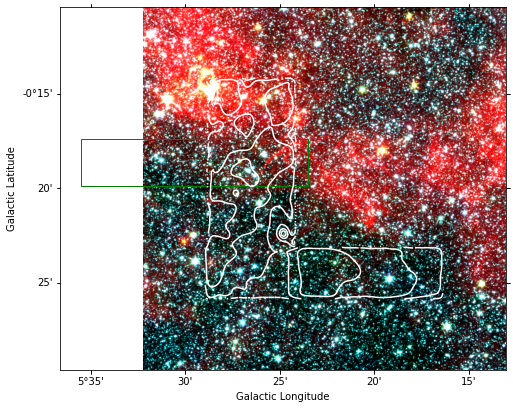

In [40]:
loc1 = '/orange/adamginsburg/cmz/g5/G5/sum/spw17_12CO/g5.mom0.smK.tot.12CO.spw17.im/'
# g5.12CO.spw17.im/ # g5.mom0.smK.tot.12CO.spw17.im/
cube = SpectralCube.read(loc1, format='casa_image')
#pbv,_ = reproject.reproject_interp(pb[10].hdu, fh[0].header)

                # 10th channel is arbitrary but avoids edge channel
#data = fh[0].data * pbv
data = cube[0].hdu.data


m0 = Projection(data, wcs=wcs.WCS(cube[0].hdu.header))


std = stats.mad_std(data, ignore_nan=True)
levels = np.array([3, 5, 10, 20, 30])*std

m0 = Projection(data, wcs=wcs.WCS(cube[0].hdu.header))
contour_levels = np.logspace(0, 5, num=25)

spitz = fits.PrimaryHDU(data=[spitzer_data[filtername][0].data for filtername in ['I4','I2','I1']], header=spitzer_data['I4'][0].header)

ax = plot_spitz(spitz, m0, contour_levels)

#r = Quadrangle((5.392, -0.3313)*u.deg, 720*u.arcsec, 150*u.arcsec,
               edgecolor='green', facecolor='none',
               transform=ax.get_transform('galactic'))
ax.add_patch(r)

#a = ICRS(Angle('00:21:38.6451 degrees'),Angle('-00:25:26.057 degrees'))

#ax.scatter(a[0],a[1], transform=ax.get_transform('icrs'), s=300,
 #          edgecolor='white', facecolor='purple')
#cor = SkyCoord('17:59:12', '-24:27:50', frame='icrs')

In [38]:
from astropy import units as u
from astropy.visualization.wcsaxes import Quadrangle
from astropy.coordinates import Angle
from astropy.coordinates import ICRS
from astropy.coordinates import SkyCoord

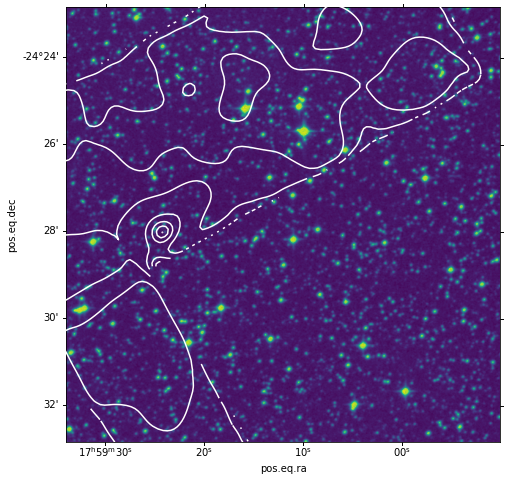

In [49]:
jsky = 'ALMA22/jsky13241953264208787586.fits'
hdul_t = fits.open(jsky)
im = hdul_t[0]
ww = wcs.WCS(im.header)
fig = pl.figure(1, figsize=(8,8))
ax = fig.add_subplot(projection=ww.celestial)
ax.imshow(im.data.T.swapaxes(0,1))
ax.contour(m0, transform=ax.get_transform(m0.wcs.celestial), levels=contour_levels, colors='white', linewidths=[1.5])

<WCSAxesSubplot:xlabel='Galactic Longitude', ylabel='Galactic Latitude'>

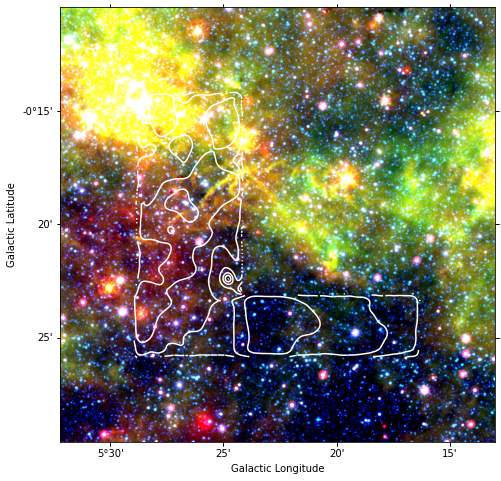

In [41]:
#cube[0].hdu.data
spitzer_data_2 = spitzer_data.copy()
spitzer_data_2['MG'] = [fits.PrimaryHDU(data=mipsdata, header=spitzer_data['I1'][0].header)]

spitz = fits.PrimaryHDU(data=[spitzer_data_2[filtername][0].data for filtername in ['MG','I4','I2']], header=spitzer_data['I4'][0].header)

plot_spitz(spitz, m0, contour_levels)
#plt.savefig('./plots/spitzer_2.pdf')

In [18]:
##### SOFIA
s_url1 = 'https://irsa.ipac.caltech.edu/data/SOFIA/GREAT/OC1C/20130724_F120/raw/r2/data/si/GREAT1_1_03/008657_003_GREAT_SAFFTS1.fits' 
s_url2 = 'https://irsa.ipac.caltech.edu/data/SOFIA/GREAT/OC1C/20130724_F120/raw/r2/data/si/GREAT1_1_03/008657_003_GREAT_CPBE1.fits'
s_url3 = 'https://irsa.ipac.caltech.edu/data/SOFIA/GREAT/OC1C/20130724_F120/raw/r2/data/si/GREAT1_1_03/008657_003_GREAT_SXFFTS1.fits'

s_fits1 = fits.open(s_url1)
s_fits2 = fits.open(s_url2)
s_fits3 = fits.open(s_url3)

shead=s_fits2[0].header

In [19]:
c = coord.SkyCoord(ra=shead['OBSRA']*u.deg, dec=shead['OBSDEC']*u.deg, equinox=shead['TELEQUI'])

In [20]:
c.galactic

<SkyCoord (Galactic): (l, b) in deg
    (304.29243304, -55.81833393)>

In [21]:
s_fits1[0].header

SIMPLE  =                    T / Written by IDL:  Tue Sep 24 15:03:04 2013      
BITPIX  =                   32 / number of bits per data pixel                  
NAXIS   =                    4 / number of data axes                            
NAXIS1  =                 8192 / length of data axis 1                          
NAXIS2  =                    1 / length of data axis 2                          
NAXIS3  =                    1 / length of data axis 3                          
NAXIS4  =                    1 / length of data axis 4                          
EXTEND  =                    T / FITS dataset may contain extensions            
DATASRC = 'ASTRO   '           / Data Source                                    
OBSTYPE = 'OBJECT  '           / Observation type                               
SRCTYPE = 'UNKNOWN '           / Source type                                    
KWDICT  = 'DCS_ICD_revE '      /SOFIA Keyword dictionary version,               
OBS_ID  = '2013-07-24_GR_F12

In [22]:
(1900536.9*u.MHz).to(u.THz)

<Quantity 1.9005369 THz>

In [23]:
15*u.arcsec

<Quantity 15. arcsec>

In [24]:
u.pixel_scale(u.pixel/15*u.arcsec)

[(Unit("pix"), Unit("15 / arcsec"))]

## Herschel

In [154]:
herfn_1 = '/orange/adamginsburg/higal/Field4_0_Combined_SPIRE_SpirePacsParallel_250_1342214761-1342214762_extd.fits'
herfn_2 = '/orange/adamginsburg/higal/Field4_0_Combined_SPIRE_SpirePacsParallel_350_1342214761-1342214762_extd.fits'
herfn_3 = '/orange/adamginsburg/higal/Field4_0_Combined_SPIRE_SpirePacsParallel_500_1342214761-1342214762_extd.fits'
pacsfn_1 = '/orange/adamginsburg/higal/Field4_0_PACS_SpirePacsParallel_160_1342214761-1342214762_jscanam.fits'
pacsfn_2 = '/orange/adamginsburg/higal/Field4_0_PACS_SpirePacsParallel_70_1342214761-1342214762_jscanam.fits'


In [170]:
her = fits.open(herfn_3)

In [171]:
type(her[0].data)

NoneType

In [172]:
#her[0].header

In [173]:
def plot_her(her, image, contour_levels):
    #spitz = spitz[0]
    ww = wcs.WCS(her[0].header)
    
    #ww = wcs.WCS(image.header)
    #print(ww.proj_plane_pixel_scales)
    fig = pl.figure(1, figsize=(8,8))
    #fig.ckf()
    ax = fig.add_subplot(projection=ww.celestial)
    spitzer_display_args=dict(stretch='asinh', min_percent=7, max_percent=90., clip=True)
    #spitz_data = simple_norm(spitz.data, **spitzer_display_args)(spitz.data)
    spitz_data = np.array([simple_norm(x, **spitzer_display_args)(x) for x in her[1].data])
    ax.imshow(spitz_data.T.swapaxes(0,1))
    lims = ax.axis()
    ax.contour(image, transform=ax.get_transform(image.wcs.celestial), levels=contour_levels, colors='magenta', linewidths=[1.5])
    ax.coords['ra'].set_axislabel('Right Ascension')
    ax.coords['dec'].set_axislabel('Declination')
    
    c_icrs = coord.SkyCoord(ra=5.4*u.degree, dec=-0.4*u.degree, frame='icrs')
    
    #ax.scatter(304.29243304, -55.81833393, transform=ax.get_transform(image.wcs.celestial), s=s,
    #       edgecolor='cyan')
    ax.scatter(5.4, -0.4, transform=ax.get_transform('galactic'), s=300,
           edgecolor='white', facecolor='none')
    
    return ax
    #ax.coords['glon'].set_axislabel('Galactic Longitude')
    #ax.coords['glat'].set_axislabel('Galactic Latitude')


In [174]:
from astropy import stats, convolution, wcs, coordinates

loc1 = '/orange/adamginsburg/cmz/g5/G5/sum/spw17_12CO/g5.mom0.smK.tot.12CO.spw17.im/'
# g5.12CO.spw17.im/ # g5.mom0.smK.tot.12CO.spw17.im/
cube = SpectralCube.read(loc1, format='casa_image')
#pbv,_ = reproject.reproject_interp(pb[10].hdu, fh[0].header)

                # 10th channel is arbitrary but avoids edge channel
#data = fh[0].data * pbv
data = cube[0].hdu.data

std = stats.mad_std(data, ignore_nan=True)
levels = np.array([3, 5, 10, 20, 30])*std

m0 = Projection(data, wcs=wcs.WCS(cube[0].hdu.header))
contour_levels = np.logspace(0, 5, num=25)


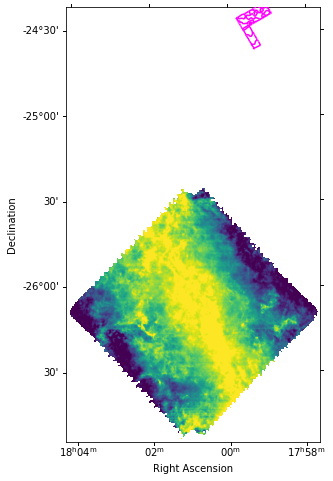

In [175]:
ax = plot_her(her, m0, contour_levels)

In [123]:
pos = (5.4*u.deg, -0.4*u.deg)
c_icrs = coord.SkyCoord(ra=5.4*u.degree, dec=-0.4*u.degree, frame='icrs')

In [120]:
from astropy import stats, convolution, wcs, coordinates

#wcs = wcs.WCS(her[0].header)
data = her[1].data

cutout = Cutout2D(data, c_icrs, (5, 5), wcs=wcs, mode='partial')
plt.imshow(cutout.data, origin='lower')

ValueError: Input position contains invalid values (NaNs or infs).

In [168]:
pacs = fits.open(pacsfn_1)

In [169]:
plot_her(pacs, m0, contour_levels)

IndexError: index 0 is out of bounds for axis 1 with size 0

<Figure size 576x576 with 0 Axes>

In [2]:
loc_sio = '/orange/adamginsburg/cmz/g5/G5/sum/spw27_SiO/g5.mom0.smK.tot.SiO.spw27.im/'

sio = SpectralCube.read(loc_sio, format='casa_image')

sio.quicklook()

/blue/adamginsburg/adamginsburg/repos/casa-formats-io/casa_formats_io/casa_dask.py:247: RuntimeWarning: divide by zero encountered in long_scalars
  factors = [f for f in range(stacks[dim] + 1) if stacks[dim] % f == 0]


AttributeError: 'DaskSpectralCube' object has no attribute 'quicklook'

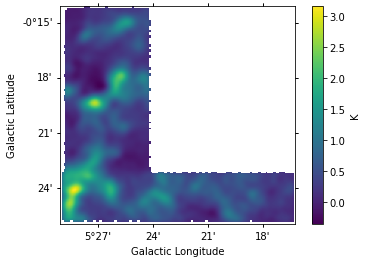

In [16]:
with quantity_support():
    plt.figure()
    ax = plt.subplot(111, projection=sio.wcs.celestial)
    plt.imshow(sio[0].value)
    cbar = plt.colorbar()
    cbar.set_label('K')
    ax.coords['glon'].set_axislabel('Galactic Longitude')
    ax.coords['glat'].set_axislabel('Galactic Latitude')
    plt.savefig('plots/sio_m0.pdf')